# Comparação de modelos para previsão de obesidade

Notebook exploratório para treinar e comparar RandomForest e XGBoost usando o dataset `Obesity.csv`.

## Carregamento e visão geral dos dados

In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/Obesity.csv')
df.head()


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Tratamento e tradução

In [159]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'Obesity'],
      dtype='object')

In [160]:
# renomeação das colunas conforme as descrições do dicionário
colunas_map = {
    'Gender': 'Genero',
    'Age': 'Idade',
    'Height': 'Altura',
    'Weight': 'Peso',
    'family_history': 'Historico_Familiar_Sobrepeso',
    'FAVC': 'Consumo_Calorico_Frequente',
    'FCVC': 'Consumo_Vegetais',
    'NCP': 'Numero_Refeicoes_Principais',
    'CAEC': 'Consumo_Alimentos_Entre_Refeicoes',
    'SMOKE': 'Fumante',
    'CH2O': 'Consumo_Agua_Diario',
    'SCC': 'Monitoramento_Calorias',
    'FAF': 'Atividade_Fisica_Frequencia',
    'TUE': 'Tempo_Dispositivos_Tecnologicos',
    'CALC': 'Consumo_Alcool',
    'MTRANS': 'Meio_Transporte',
    'Obesity': 'Nivel_Obesidade'
}

df = df.rename(columns=colunas_map)

# arredondamento de valores decimais ("ruído") conforme instruções do dicionário
# colunas que devem ser inteiras: FCVC, NCP, CH2O, FAF, TUE
cols_para_arredondar = [
    'Consumo_Vegetais', 'Numero_Refeicoes_Principais', 
    'Consumo_Agua_Diario', 'Atividade_Fisica_Frequencia', 
    'Tempo_Dispositivos_Tecnologicos'
]

for col in cols_para_arredondar:
    if col in df.columns:
        df[col] = df[col].round().astype(int)

# dicionários de tradução dos valores internos
traducoes_valores = {
    'Genero': {'Female': 'Feminino', 'Male': 'Masculino'},
    'Historico_Familiar_Sobrepeso': {'yes': 'Sim', 'no': 'Não'},
    'Consumo_Calorico_Frequente': {'yes': 'Sim', 'no': 'Não'},
    'Fumante': {'yes': 'Sim', 'no': 'Não'},
    'Monitoramento_Calorias': {'yes': 'Sim', 'no': 'Não'},
    'Consumo_Alimentos_Entre_Refeicoes': {
        'no': 'Não', 'Sometimes': 'Às vezes', 'Frequently': 'Frequentemente', 'Always': 'Sempre'
    },
    'Consumo_Alcool': {
        'no': 'Não', 'Sometimes': 'Às vezes', 'Frequently': 'Frequentemente', 'Always': 'Sempre'
    },
    'Meio_Transporte': {
        'Automobile': 'Carro', 
        'Motorbike': 'Moto', 
        'Bike': 'Bicicleta', 
        'Public_Transportation': 'Transporte Público', 
        'Walking': 'Caminhada'
    },
    'Nivel_Obesidade': {
        'Insufficient_Weight': 'Abaixo do Peso',
        'Normal_Weight': 'Peso Normal',
        'Overweight_Level_I': 'Sobrepeso I',
        'Overweight_Level_II': 'Sobrepeso II',
        'Obesity_Type_I': 'Obesidade I',
        'Obesity_Type_II': 'Obesidade II',
        'Obesity_Type_III': 'Obesidade III'
    }
}

# aplicando as traduções
for coluna, mapeamento in traducoes_valores.items():
    if coluna in df.columns:
        df[coluna] = df[coluna].map(mapeamento)


df

,Genero,Idade,Altura,Peso,Historico_Familiar_Sobrepeso,Consumo_Calorico_Frequente,Consumo_Vegetais,Numero_Refeicoes_Principais,Consumo_Alimentos_Entre_Refeicoes,Fumante,Consumo_Agua_Diario,Monitoramento_Calorias,Atividade_Fisica_Frequencia,Tempo_Dispositivos_Tecnologicos,Consumo_Alcool,Meio_Transporte,Nivel_Obesidade
0,Feminino,21.000000,1.620000,64.000000,Sim,Não,2,3,Às vezes,Não,2,Não,0,1,Não,Transporte Público,Peso Normal
1,Feminino,21.000000,1.520000,56.000000,Sim,Não,3,3,Às vezes,Sim,3,Sim,3,0,Às vezes,Transporte Público,Peso Normal
2,Masculino,23.000000,1.800000,77.000000,Sim,Não,2,3,Às vezes,Não,2,Não,2,1,Frequentemente,Transporte Público,Peso Normal
3,Masculino,27.000000,1.800000,87.000000,Não,Não,3,3,Às vezes,Não,2,Não,2,0,Frequentemente,Caminhada,Sobrepeso I
4,Masculino,22.000000,1.780000,89.800000,Não,Não,2,1,Às vezes,Não,2,Não,0,0,Às vezes,Transporte Público,Sobrepeso II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Feminino,20.976842,1.710730,131.408528,Sim,Sim,3,3,Às vezes,Não,2,Não,2,1,Às vezes,Transporte Público,Obesidade III
2107,Feminino,21.982942,1.748584,133.742943,Sim,Sim,3,3,Às vezes,Não,2,Não,1,1,Às vezes,Transporte Público,Obesidade III
2108,Feminino,22.524036,1.752206,133.689352,Sim,Sim,3,3,Às vezes,Não,2,Não,1,1,Às vezes,Transporte Público,Obesidade III
2109,Feminino,24.361936,1.739450,133.346641,Sim,Sim,3,3,Às vezes,Não,3,Não,1,1,Às vezes,Transporte Público,Obesidade III


### Análise preliminar

In [161]:
print('Dimensões:', df.shape)
print('Valores nulos por coluna:')
print(df.isnull().sum())

Dimensões: (2111, 17)
Valores nulos por coluna:
Genero                               0
Idade                                0
Altura                               0
Peso                                 0
Historico_Familiar_Sobrepeso         0
Consumo_Calorico_Frequente           0
Consumo_Vegetais                     0
Numero_Refeicoes_Principais          0
Consumo_Alimentos_Entre_Refeicoes    0
Fumante                              0
Consumo_Agua_Diario                  0
Monitoramento_Calorias               0
Atividade_Fisica_Frequencia          0
Tempo_Dispositivos_Tecnologicos      0
Consumo_Alcool                       0
Meio_Transporte                      0
Nivel_Obesidade                      0
dtype: int64


Distribuição da variável alvo.

In [162]:
df.describe().round()

,Idade,Altura,Peso,Consumo_Vegetais,Numero_Refeicoes_Principais,Consumo_Agua_Diario,Atividade_Fisica_Frequencia,Tempo_Dispositivos_Tecnologicos
count,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0
mean,24.0,2.0,87.0,2.0,3.0,2.0,1.0,1.0
std,6.0,0.0,26.0,1.0,1.0,1.0,1.0,1.0
min,14.0,1.0,39.0,1.0,1.0,1.0,0.0,0.0
25%,20.0,2.0,65.0,2.0,3.0,2.0,0.0,0.0
50%,23.0,2.0,83.0,2.0,3.0,2.0,1.0,1.0
75%,26.0,2.0,107.0,3.0,3.0,2.0,2.0,1.0
max,61.0,2.0,173.0,3.0,4.0,3.0,3.0,2.0


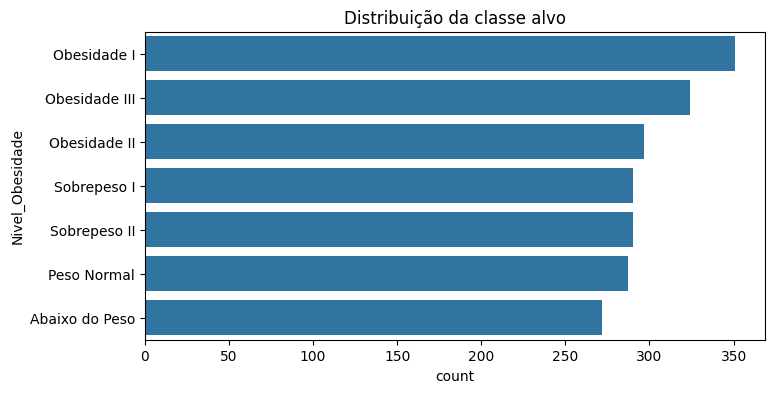

In [163]:
plt.figure(figsize=(8,4))
sns.countplot(y='Nivel_Obesidade', data=df, order=df['Nivel_Obesidade'].value_counts().index, )
plt.title('Distribuição da classe alvo')
plt.show()

In [164]:
#  gráfico por cluster - peso x altura - cluster nivel de obesidade

fig = px.scatter(
    df, 
    x="Peso", 
    y="Altura", 
    size="Idade",           # O tamanho da bolha representa a idade
    color="Nivel_Obesidade",      # A cor representa o nível de obesidade
    hover_name="Genero",  # Informação extra ao passar o mouse
    title="Análise de relação peso, altura e idade (Tamanho)",
    labels={
        "Weight": "Peso",
        "Height": "Altura",
        "Obesity": "Nível de Obesidade"
    })

# Ajustando a legenda e layout para ficar igual ao print
fig.update_layout(
    legend_title_text='Nível de Obesidade',
    title_x=0.05  # Alinha o título à esquerda
)

fig.show()

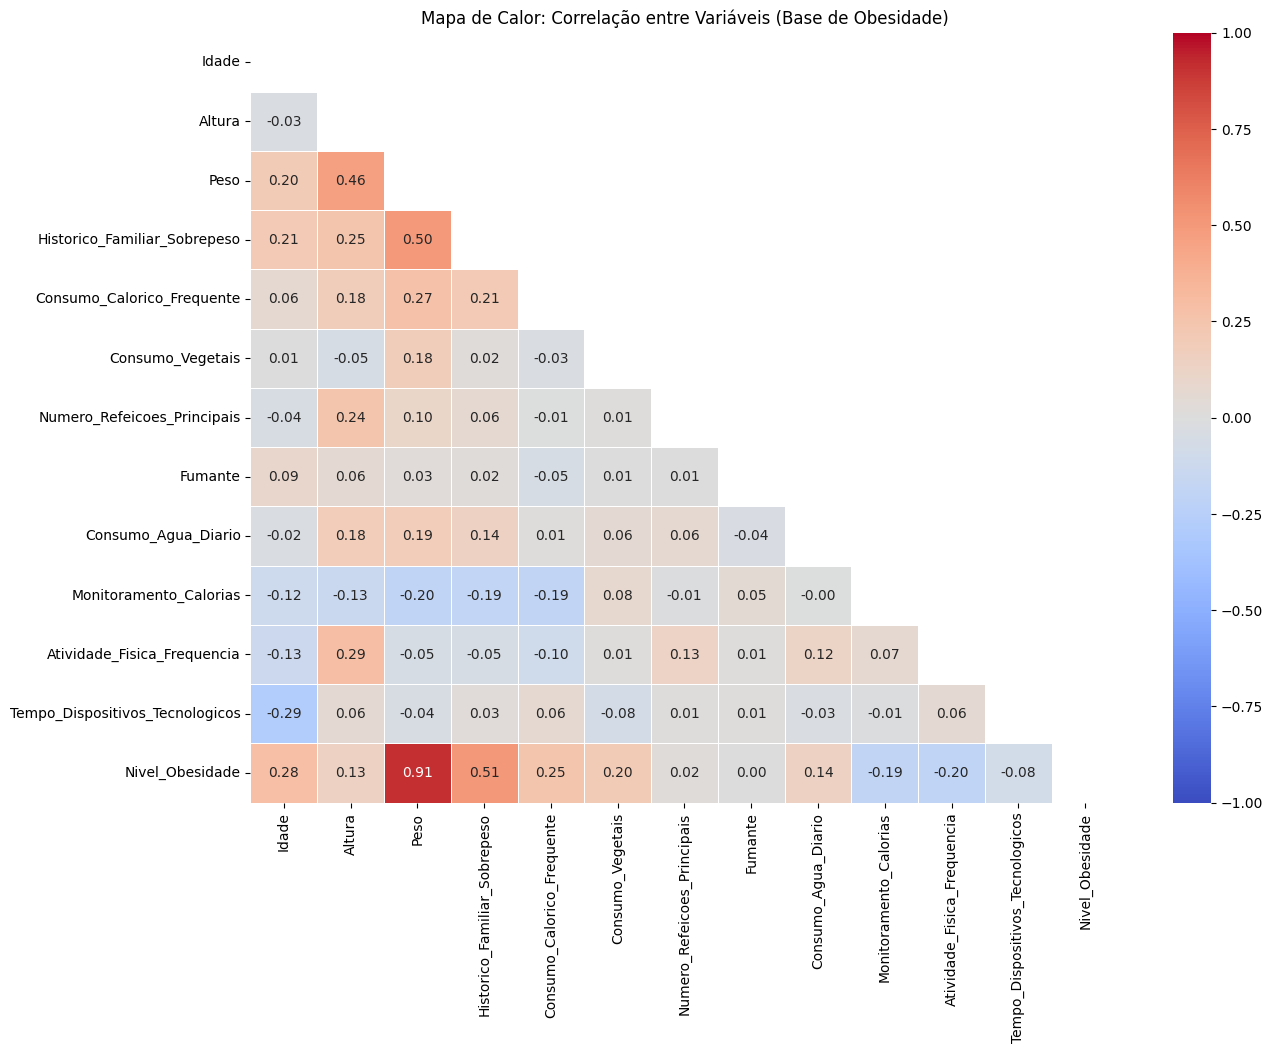

In [165]:
# heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Preparando o DF: Apenas colunas numéricas ou transformadas
# Criamos uma cópia para não afetar o original
df_corr = df.copy()

# Transformando variáveis binárias em 0 e 1 para entrarem na correlação
binarias = ['Historico_Familiar_Sobrepeso', 'Consumo_Calorico_Frequente', 'Fumante', 'Monitoramento_Calorias']
for col in binarias:
    df_corr[col] = df_corr[col].map({'Sim': 1, 'Não': 0})

# Transformando a Escala de Obesidade em Numérica (Ordinal) para correlação
obesidade_ordem = {
    'Abaixo do Peso': 0, 'Peso Normal': 1, 'Sobrepeso I': 2, 
    'Sobrepeso II': 3, 'Obesidade I': 4, 'Obesidade II': 5, 'Obesidade III': 6
}
df_corr['Nivel_Obesidade'] = df_corr['Nivel_Obesidade'].map(obesidade_ordem)

# 2. Calculando a Matriz de Correlação
corr = df_corr.select_dtypes(include=[np.number]).corr()

# 3. Gerando o Heatmap
plt.figure(figsize=(14, 10))

# Criando uma máscara para esconder a parte de cima (triângulo superior) que é repetida
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, 
    mask=mask, 
    annot=True,          # Mostra os valores dentro dos quadrados
    fmt=".2f",           # Duas casas decimais
    cmap='coolwarm',     # Cores: azul (negativo), branco (neutro), vermelho (positivo)
    vmin=-1, vmax=1,     # Garante que a escala vá de -1 a 1
    center=0,
    linewidths=.5
)

plt.title('Mapa de Calor: Correlação entre Variáveis (Base de Obesidade)')
plt.show()

## Preparação dos dados e divisão em treino/teste

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# 1. Ajuste da Feature Engineering com nomes traduzidos
def engineer_features(df):
    df = df.copy()
    # Mapeamento baseado nas escalas do dicionário [cite: 9, 12, 17, 20, 21]
    bins_map = {
        'Consumo_Vegetais': ([0, 1.5, 2.5, 4], ['baixa', 'moderada', 'alta']), # FCVC
        'Numero_Refeicoes_Principais': ([0, 2.5, 3.5, 10], ['1-2', '3', '4+']), # NCP
        'Consumo_Agua_Diario': ([0, 1.5, 2.5, 10], ['<1L', '1-2L', '>2L']), # CH2O
        'Atividade_Fisica_Frequencia': ([0, 0.5, 1.5, 2.5, 10], ['nenhuma', 'baixa', 'media', 'alta']), # FAF
        'Tempo_Dispositivos_Tecnologicos': ([0, 0.5, 1.5, 10], ['0-2h', '3-5h', '>5h']), # TUE
    }
    
    for col, (bins, labels) in bins_map.items():
        if col in df.columns:
            # Garante que os dados sejam numéricos antes do cut (caso tenham sido arredondados para int)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            cat = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True, right=False)
            df[col] = cat.astype(str)
    return df

# 2. Definição do Alvo e Variáveis com nomes traduzidos
TARGET = 'Nivel_Obesidade' # Obesity [cite: 25]
X = df.drop(columns=[TARGET])
y = df[TARGET]

# 3. Identificação de colunas após engenharia de recursos
engineered_sample = engineer_features(X.head())
cat_cols = engineered_sample.select_dtypes(include=['object', 'category']).columns
num_cols = engineered_sample.select_dtypes(exclude=['object', 'category']).columns

# 4. Pipeline de Preprocessamento
preprocess = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('numeric', 'passthrough', num_cols),
])

# 5. Label Encoding do Alvo Traduzido
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 6. Lógica de Risco Atualizada para Português
# Define classes de risco (Sobrepeso e Obesidade) conforme dicionário 
RISK_CLASSES = [
    'Sobrepeso I', 'Sobrepeso II', 
    'Obesidade I', 'Obesidade II', 'Obesidade III'
]

def to_risk_flag(y_encoded_vals):
    labels = label_encoder.inverse_transform(y_encoded_vals)
    return np.array([1 if lbl in RISK_CLASSES else 0 for lbl in labels])

# 7. Split dos Dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Classes mapeadas pelo LabelEncoder:", label_encoder.classes_)

Classes mapeadas pelo LabelEncoder: ['Abaixo do Peso' 'Obesidade I' 'Obesidade II' 'Obesidade III'
 'Peso Normal' 'Sobrepeso I' 'Sobrepeso II']


## Treino e avaliação dos modelos

In [167]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SkPipeline

# Lista para armazenar e comparar os resultados posteriores
results = []

# 1. Função SEM SMOTE (Pipeline padrão do Scikit-Learn)
def train_and_evaluate_n_smote(name, estimator):
    pipe = SkPipeline([
        ('feature_engineering', feature_engineering),
        ('columns', preprocess),
        ('model', estimator),
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    # to_risk_flag utiliza as classes traduzidas para identificar riscos 
    recall_risk = recall_score(to_risk_flag(y_test), to_risk_flag(preds), zero_division=0)
    
    print(f"=== {name} (Sem SMOTE) ===")
    print(f"Acuracia: {acc:.3f} | F1-macro: {f1:.3f} | Recall risco: {recall_risk:.3f}")
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))
    
    results.append({
        'name': f"{name}_sem_smote", 
        'pipeline': pipe, 
        'accuracy': acc, 
        'f1': f1, 
        'recall_risk': recall_risk,
        'smote': False
    })

# 2. Função COM SMOTE (Pipeline do Imbalanced-Learn)
def train_and_evaluate(name, estimator):
    # É necessário usar o Pipeline do imblearn para que o SMOTE só atue no treino
    pipe = ImbPipeline([
        ('feature_engineering', feature_engineering),
        ('columns', preprocess),
        ('sampler', SMOTE(random_state=42)),
        ('model', estimator),
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    recall_risk = recall_score(to_risk_flag(y_test), to_risk_flag(preds), zero_division=0)
    
    print(f"=== {name} (Com SMOTE) ===")
    print(f"Acuracia: {acc:.3f} | F1-macro: {f1:.3f} | Recall risco: {recall_risk:.3f}")
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))
    
    results.append({
        'name': f"{name}", 
        'pipeline': pipe, 
        'accuracy': acc, 
        'f1': f1, 
        'recall_risk': recall_risk,
        'smote': True
    })

# Random Forest

In [168]:

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample',
)


train_and_evaluate_n_smote('RandomForest_n_smote', rf)
train_and_evaluate('RandomForest', rf)


=== RandomForest_n_smote (Sem SMOTE) ===
Acuracia: 0.922 | F1-macro: 0.921 | Recall risco: 0.958
                precision    recall  f1-score   support

Abaixo do Peso       0.98      0.94      0.96        54
   Obesidade I       0.97      0.94      0.96        70
  Obesidade II       1.00      1.00      1.00        60
 Obesidade III       1.00      1.00      1.00        65
   Peso Normal       0.75      0.83      0.79        58
   Sobrepeso I       0.86      0.83      0.84        58
  Sobrepeso II       0.90      0.90      0.90        58

      accuracy                           0.92       423
     macro avg       0.92      0.92      0.92       423
  weighted avg       0.92      0.92      0.92       423

=== RandomForest (Com SMOTE) ===
Acuracia: 0.922 | F1-macro: 0.920 | Recall risco: 0.965
                precision    recall  f1-score   support

Abaixo do Peso       0.98      0.93      0.95        54
   Obesidade I       1.00      0.94      0.97        70
  Obesidade II       1.00 

Recall: O modelo consegue capturar 96,5% de todos os casos que pertencem a alguma categoria de risco (Sobrepeso ou Obesidade).

- Sem o SMOTE o recall cai

# LighGBM

In [169]:
lgbm = LGBMClassifier(
    n_estimators=39,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42,
    n_jobs=4,
)

train_and_evaluate('LightGBM', lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 1967, number of used features: 40
[LightGBM] [Info] Start training from score -1,945910
[LightGBM] [Info] Start training from score -1,945910
[LightGBM] [Info] Start training from score -1,945910
[LightGBM] [Info] Start training from score -1,945910
[LightGBM] [Info] Start training from score -1,945910
[LightGBM] [Info] Start training from score -1,945910
[LightGBM] [Info] Start training from score -1,945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

# XGBoost

In [170]:
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    num_class=len(label_encoder.classes_),
    n_jobs=4,
)

train_and_evaluate('XGBoost', xgb)

=== XGBoost (Com SMOTE) ===
Acuracia: 0.962 | F1-macro: 0.961 | Recall risco: 0.994
                precision    recall  f1-score   support

Abaixo do Peso       0.98      0.93      0.95        54
   Obesidade I       0.99      0.97      0.98        70
  Obesidade II       0.98      1.00      0.99        60
 Obesidade III       1.00      0.98      0.99        65
   Peso Normal       0.90      0.93      0.92        58
   Sobrepeso I       0.93      0.93      0.93        58
  Sobrepeso II       0.95      0.98      0.97        58

      accuracy                           0.96       423
     macro avg       0.96      0.96      0.96       423
  weighted avg       0.96      0.96      0.96       423



# Avaliação dos modelos

In [171]:
summary = pd.DataFrame([
    {
        'Modelo': r['name'],
        'Acuracia %': round(r['accuracy']*100,2),
        'F1-macro %': round(r['f1']*100,2),
        'Recall risco %': round(r['recall_risk']*100,2),
    } for r in results
]).sort_values(by='Recall risco %', ascending=False)
summary

,Modelo,Acuracia %,F1-macro %,Recall risco %
3,XGBoost,96.22,96.10,99.36
2,LightGBM,95.51,95.41,99.04
1,RandomForest,92.20,92.03,96.46
0,RandomForest_n_smote_sem_smote,92.20,92.06,95.82


# Teste de overfitting

In [172]:
def check_overfitting(name, pipeline):
    # Predições para treino e teste
    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)
    
    # Cálculo das métricas
    acc_train = accuracy_score(y_train, train_preds)
    acc_test = accuracy_score(y_test, test_preds)
    
    f1_train = f1_score(y_train, train_preds, average='macro')
    f1_test = f1_score(y_test, test_preds, average='macro')
    
    print(f"--- Teste de Overfitting: {name} ---")
    print(f"Acurácia - Treino: {acc_train:.3f} | Teste: {acc_test:.3f} | Diff: {acc_train - acc_test:.3f}")
    print(f"F1-Macro - Treino: {f1_train:.3f} | Teste: {f1_test:.3f} | Diff: {f1_train - f1_test:.3f}")
    
    if (acc_train - acc_test) > 0.10:
        print("ALERTA: Possível Overfitting detectado! (Diferença maior que 10%)")
    else:
        print("O modelo parece estar generalizando bem.")

In [173]:
# Percorre cada item dentro da lista de resultados
for item in results:
    # Extrai o nome e o pipeline salvos
    nome_modelo = item['name']
    pipeline_modelo = item['pipeline']
    
    # Chama a função de teste de overfitting para cada um
    check_overfitting(nome_modelo, pipeline_modelo)
    print("-" * 30) # Linha separadora para facilitar a leitura

--- Teste de Overfitting: RandomForest_n_smote_sem_smote ---
Acurácia - Treino: 1.000 | Teste: 0.922 | Diff: 0.078
F1-Macro - Treino: 1.000 | Teste: 0.920 | Diff: 0.080
O modelo parece estar generalizando bem.
------------------------------
--- Teste de Overfitting: RandomForest ---
Acurácia - Treino: 1.000 | Teste: 0.922 | Diff: 0.078
F1-Macro - Treino: 1.000 | Teste: 0.920 | Diff: 0.080
O modelo parece estar generalizando bem.
------------------------------
--- Teste de Overfitting: LightGBM ---
Acurácia - Treino: 0.997 | Teste: 0.955 | Diff: 0.042
F1-Macro - Treino: 0.997 | Teste: 0.954 | Diff: 0.043
O modelo parece estar generalizando bem.
------------------------------
--- Teste de Overfitting: XGBoost ---
Acurácia - Treino: 1.000 | Teste: 0.962 | Diff: 0.038
F1-Macro - Treino: 1.000 | Teste: 0.961 | Diff: 0.039
O modelo parece estar generalizando bem.
------------------------------


### XGBoost performou como melhor modelo

## Salvar artefatos para uso no app Streamlit

In [174]:
import dill
import joblib

# Configuramos o joblib para usar o dill para serialização
for r in results:
    artifact = {'pipeline': r['pipeline'], 'label_encoder': label_encoder}
    filename = models_dir / f"{r['name'].lower()}.pkl"
    
    with open(filename, 'wb') as f:
        dill.dump(artifact, f)

# Salva o label_encoder separadamente também com dill por consistência
with open(models_dir / 'label_encoder.pkl', 'wb') as f:
    dill.dump(label_encoder, f)

print('Artefatos salvos com sucesso!')

Artefatos salvos com sucesso!


# Exportar o DF tratado

In [175]:
df_tratado = engineer_features(df)
df_tratado

,Genero,Idade,Altura,Peso,Historico_Familiar_Sobrepeso,Consumo_Calorico_Frequente,Consumo_Vegetais,Numero_Refeicoes_Principais,Consumo_Alimentos_Entre_Refeicoes,Fumante,Consumo_Agua_Diario,Monitoramento_Calorias,Atividade_Fisica_Frequencia,Tempo_Dispositivos_Tecnologicos,Consumo_Alcool,Meio_Transporte,Nivel_Obesidade
0,Feminino,21.000000,1.620000,64.000000,Sim,Não,moderada,3,Às vezes,Não,1-2L,Não,nenhuma,3-5h,Não,Transporte Público,Peso Normal
1,Feminino,21.000000,1.520000,56.000000,Sim,Não,alta,3,Às vezes,Sim,>2L,Sim,alta,0-2h,Às vezes,Transporte Público,Peso Normal
2,Masculino,23.000000,1.800000,77.000000,Sim,Não,moderada,3,Às vezes,Não,1-2L,Não,media,3-5h,Frequentemente,Transporte Público,Peso Normal
3,Masculino,27.000000,1.800000,87.000000,Não,Não,alta,3,Às vezes,Não,1-2L,Não,media,0-2h,Frequentemente,Caminhada,Sobrepeso I
4,Masculino,22.000000,1.780000,89.800000,Não,Não,moderada,1-2,Às vezes,Não,1-2L,Não,nenhuma,0-2h,Às vezes,Transporte Público,Sobrepeso II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Feminino,20.976842,1.710730,131.408528,Sim,Sim,alta,3,Às vezes,Não,1-2L,Não,media,3-5h,Às vezes,Transporte Público,Obesidade III
2107,Feminino,21.982942,1.748584,133.742943,Sim,Sim,alta,3,Às vezes,Não,1-2L,Não,baixa,3-5h,Às vezes,Transporte Público,Obesidade III
2108,Feminino,22.524036,1.752206,133.689352,Sim,Sim,alta,3,Às vezes,Não,1-2L,Não,baixa,3-5h,Às vezes,Transporte Público,Obesidade III
2109,Feminino,24.361936,1.739450,133.346641,Sim,Sim,alta,3,Às vezes,Não,>2L,Não,baixa,3-5h,Às vezes,Transporte Público,Obesidade III


In [176]:
df_tratado.to_excel('../data/df_tratado_obesidade.xlsx', index=False)